# Tutorial 3.2. Response of a MDoF system 

### Description: Structural system may be modeled as a multi degree of freedom - MDoF - system for finding the responses under various loads. Static, eigenvalue and dynamic analysis of a MDoF system is presented. The response of a MDoF system under dynamic (wind) loads may be computed by different direct time integration schemes. These are presented here. Some exercises are proposed. 

#### Students are advised to complete the exercises. 

Project: Structural Wind Engineering WS19-20 
        Chair of Structural Analysis @ TUM - R. Wüchner, M. Péntek, A. Kodakkal
        
Author: anoop.kodakkal@tum.de mate.pentek@tum.de

Created on:  24.11.2016

Last update: 16.11.2020

##### Contents

1. Structural response of a MDoF system under static and dynamic loads
2. Eigenvalue analysis of a MDoF system  
3. Comparison of the performance and accuracy of different numerical (time) integration schemes 

In [1]:
# import python modules
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from matplotlib import animation, rc

# import own modules
import structure_mdof as s_mdof

#### Creating the time instances as an array

The start time, end time and the number of time steps are specified here for generating the time series. 

In [2]:
# start time
start_time = 0.0
# end time
end_time = 10.0
# steps 
n_steps = 1000
# time step
delta_time = end_time / (n_steps-1)
# time series
# generate grid size vectors 1D
time_series = np.arange(start_time, end_time + delta_time, delta_time)

### Modeling the structure

#### The structure is modeled as MDoF system with masses lumped at floor levels. Only the translational degrees of freedom are considered at each of the floor levels, so that it behaves as a pure shear-type cantilever beam. 

<img src="example_mdof_111_akchopra.png" alt="Drawing" style="width: 500px;"/>

The picture is adapted from from example 11.1 A.K. Chopra (1995)

##### The mass and stiffness matrices of a 3 DoF system have the following structure in this case

\begin{gather}
 K = \begin{bmatrix} 
 k_{1}+k_{2} & -k_{2} & 0 \\
 -k_{2} & k_{2}+k_{3} & -k_{3} \\
 0 & -k_{3} & k_{3} 
 \end{bmatrix}
\end{gather}
 


\begin{gather}
 M = \begin{bmatrix} 
 m_{1} & 0 & 0 \\
 0 & m_{2} & 0 \\
 0 & 0 & m_{3} 
 \end{bmatrix}
\end{gather}

where, $k_{1}$ and $m_{1}$ are the stiffness and mass at each level. 


Interested readers may refer to:  

[A.K. Chopra, Dynamics of Structures: Theory and Applications to Earthquake Engineering, 
Person Prentice Hall, 2014](https://opac-ub-tum-de.eaccess.ub.tum.de/TouchPoint/perma.do?q=+1035%3D%22BV043635029%22+IN+%5B2%5D&v=tum&l=de)

[C. Petersen, Dynamik der Baukonstruktionen, 2017](https://link-springer-com.eaccess.ub.tum.de/book/10.1007%2F978-3-8348-2109-6) 

for detailed descriptions.

###### 3 DoF with given stiffness and mass matrix 

The mass and stiffness values of the 3 DoF are from example 11.1 A.K. Chopra (1995)

In [3]:
# stiffness matrix of the structure
k = 610 * np.array([[ 2, -1,  0],
                    [-1,  2, -1],
                    [ 0, -1,  1]])

# mass matrix of the structure
m = 1/386 * np.array([[400, 0, 0],
                      [0, 400, 0],
                      [0, 0, 200]])

number_of_floors = 3
level_height = 3.5
z = np.zeros(number_of_floors+1)
for i in range(number_of_floors+1):
    z[i] = level_height * i

z is the array of height coordinates.

### 3.1 Static analysis

The response of the MDoF under a static load is computed.


###### Static load definition


Point load at the top 

In [4]:
# initialize with zero values for all DoFs
static_force = np.zeros(len(z)-1)
# assign to the top DoF a non-zero value
static_force[-1] = 1e2/2 #-50 [N]

###### Solving for the static displacements 

In [5]:
static_disp = np.linalg.solve(k, static_force)

###### Computing the reaction at the bottom 

In [6]:
# stiffnes at the lowest (bottom) DoF
bottom_k = k[0,0]/2
bottom_react = -bottom_k * static_disp[0] #-50 [N] 
print("Reaction at the bottom for static force: ", bottom_react, 'N')

Reaction at the bottom for static force:  -49.99999999999999 N


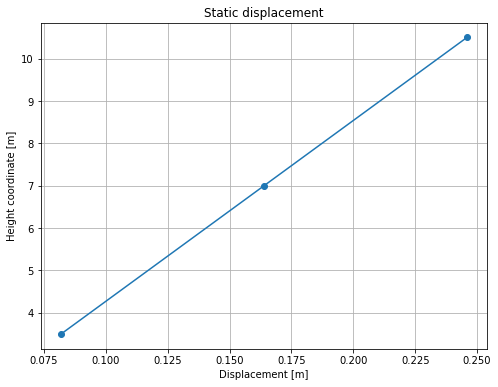

In [7]:
plt.figure(num=1, figsize=(8, 6))
plt.plot(static_disp, z[1:], marker='o')
plt.title("Static displacement")
plt.xlabel("Displacement [m]")
plt.ylabel("Height coordinate [m]")
plt.grid(True)

### 3.2 Eigenvalue analysis

Eigen value analysis is conducted to identify the mode shapes and frequency of the MDoF. 
Computing the eigenvalues, frequencies and periods of the MDoF.

In [8]:
# raw eigenvalues and eigenmodes
eig_vals_raw, eig_modes_raw = linalg.eig(k, m)

[n_row, n_col] = eig_modes_raw.shape
eig_modes_norm = np.zeros([n_row, n_col])

# natural eigenvalues, eigenfrequencis and periods of the sturcture
eig_vals = np.sqrt(np.real(eig_vals_raw)) # in rad/sec
eig_freqs = eig_vals/2/np.pi # in Hz
eig_pers = 1./eig_freqs # in s


Normalizing the modes using mass normalization.

The following checks are done for the normalization. 
1. Generalized mass should be identity
2. $\theta^T \cdot M \cdot \theta$ should numerically be $0$ for off-diagonal terms, where $\theta$ is the normalized eigen modes and $M$ is the mass matrix.


In [9]:
gen_mass_raw = np.zeros(n_col)
gen_mass_norm = np.zeros(n_col)

print("Generalized mass should be identity")
for i in range(len(eig_vals_raw)):
    gen_mass_raw[i] = (np.transpose(eig_modes_raw[:,i])).dot(m).dot(eig_modes_raw[:,i])
    unitgen_mass_norm_fact = np.sqrt(gen_mass_raw[i])
    eig_modes_norm[:,i] = eig_modes_raw[:,i]/unitgen_mass_norm_fact
    gen_mass_norm[i] = (np.transpose(eig_modes_norm[:,i])).dot(m).dot(eig_modes_norm[:,i])
    print("norm ",i,": ",gen_mass_norm[i])

print("\nMultiplication check: The off-diagonal terms of \n", 
      (np.transpose(eig_modes_norm)).dot(m).dot(eig_modes_norm), 
      " \nshould be numerically 0.")

# modal masses and modal stiffnesses result in the squared natural frequencies
modal_mass = np.zeros(n_col)
modal_stiffness = np.zeros(n_col)
check_eig_vals = np.zeros(n_col)
for i in range(len(eig_vals_raw)):
    modal_mass[i] = (np.transpose(eig_modes_norm[:,i])).dot(m).dot(eig_modes_norm[:,i])
    modal_stiffness[i] = (np.transpose(eig_modes_norm[:,i])).dot(k).dot(eig_modes_norm[:,i])
    check_eig_vals[i] = np.sqrt(modal_stiffness[i]/modal_mass[i])

Generalized mass should be identity
norm  0 :  0.9999999999999999
norm  1 :  1.0
norm  2 :  1.0

Multiplication check: The off-diagonal terms of 
 [[ 1.00000000e+00  7.61401175e-17  2.97464732e-16]
 [ 7.93698681e-17  1.00000000e+00 -7.08016255e-16]
 [ 2.91005231e-16 -6.42815852e-16  1.00000000e+00]]  
should be numerically 0.


Sorting the eigenmodes

In [10]:
eig_freq_sorted_idx = np.argsort(eig_freqs)
# extend eigenmodes -> needed only for plotting, adding value for fixed/bottom node
ext_eig_modes = np.zeros([n_row+1, n_col])
ext_eig_modes[1:,:] = eig_modes_norm 

###### Let us plot the first three eigenmodes

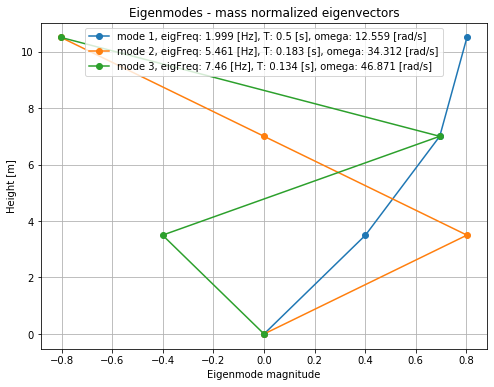

In [11]:
# plot eigenvalues and shapes
plt.figure(num=2, figsize=(8, 6))

if n_col >= 3:
    n_col_to_iterate = 3
else:
    n_col_to_iterate = n_col
for i in range(n_col_to_iterate):
    plt.plot(ext_eig_modes[:,eig_freq_sorted_idx[i]], z, marker='o',label="mode "+ str(i+1) + 
             ", eigFreq: " + str(np.round(eig_freqs[eig_freq_sorted_idx[i]],3)) + " [Hz], T: " + 
             str(np.round(eig_pers[eig_freq_sorted_idx[i]],3)) +" [s], omega: " + 
             str(np.round(eig_vals[eig_freq_sorted_idx[i]],3)) + " [rad/s]")

plt.title("Eigenmodes - mass normalized eigenvectors")
plt.xlabel("Eigenmode magnitude")
plt.ylabel("Height [m]")
plt.legend(loc='best')
plt.grid(True)

###### Let us look at the animation of the i-th eigenmode

select the mode to be animated: 

In [12]:
mode_i_idx = 1 # for naming modes - 1 to n

# shifting mode index for python convention
mode_i = mode_i_idx-1
eigenform_i = ext_eig_modes[:, eig_freq_sorted_idx[mode_i]]
omega_i = eig_vals[eig_freq_sorted_idx[mode_i]]
period_i = eig_pers[eig_freq_sorted_idx[mode_i]]
n_period = 1 # number of periods
simulTime = np.linspace(0, n_period * period_i, 20 * n_period)

# first set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(num=3, figsize=(8, 6))

ax = plt.axes(xlim=(-max(np.absolute(eigenform_i))-1/10*max(np.absolute(eigenform_i)), +max(np.absolute(eigenform_i))+1/10*max(np.absolute(eigenform_i))), ylim=(0, max(z)+1.0))
# line, = ax.plot([], [], lw=2)
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
ax.set_xlabel("Nodal position Y [m]")
ax.set_ylabel("Nodal position Z [m]")
ax.set_title("Nodal displacement plot in time [t]")
ax.grid(True)

# data placeholders
xd=np.zeros(0)
t=np.zeros(0)

# set plots
lwf=2
displ_i, = ax.plot(t,xd,'b-h', label="mode "+ str(mode_i+1) + ", eigFreq: " + str(np.round(eig_freqs[eig_freq_sorted_idx[mode_i]],3)) + " [Hz], T: " + str(np.round(eig_pers[eig_freq_sorted_idx[mode_i]],3)) +" [s], omega: " + str(np.round(eig_vals[eig_freq_sorted_idx[mode_i]],3)) + " [rad/s]", lw = lwf)
ax.legend([displ_i], [displ_i.get_label()])

# animation function
# this is called sequentially
def animate(i):
    global x
    global yp
    global t

    # plot the time
    time = simulTime[i]
    time_text.set_text('time = %.2f' % time)

    displacement_y_i = eigenform_i * np.sin(omega_i * time)

    displ_i.set_data(displacement_y_i, z)
    
    return displ_i

# call the animator.  blit=True means only re-draw the parts that have changed.
# interval: draw new frame every 'interval' ms
anim = animation.FuncAnimation(fig, animate, blit=False, frames=len(simulTime), interval=100, repeat=True)
plt.close() # prevents inline display

__ffmpeg__ is required for the animationplots. 

use the following command in anaconda prompt


_conda install -c conda-forge ffmpeg_

or 

Download and extract for (refer to slide no 19 in SWE_WS2021_InstallationGuides.pdf)
1. [Windows](https://www.ffmpeg.org/download.html)
2. [Other OS](https://www.ffmpeg.org/download.html) 



__specify the path to ffmpeg in Block 13__

In [13]:
# no need to specifz the path if installed through conda
# on windows
#plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\ga39med\\Downloads\\ffmpeg402\\bin\\ffmpeg.exe'
#plt.rcParams['animation.ffmpeg_path'] = 'C:\\Software\\ffmpeg-4.1\\bin\\ffmpeg.exe'
# on linux
#plt.rcParams['animation.ffmpeg_path'] = '~/software/anaconda/envs/env_name/bin/ffmpeg' 

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
anim

__Try to visualize other eigen modes of the structure__

### 3.3 Dynamic analysis

The response of MDoF under dynamic loading is computed by different time integration. Three time integration is presented in this section. 
1. __Generalised-Alpha__
2. __Euler First and Second Order__

_THE OBJECT-ORIENTED GENERALIZED-ALPHA SOLVER
Implementation adapted from I. Hanzlicek (2014). Original implementation by M. Andre described in: Formulation of the Generalized-Alpha method for LAGRANGE. Technical Report, Chair of Structural Analysis @TUM, 2012.
See J. Chung, G.M. Hulbert: A time integration algorithm for structural dynamics
wih improved numerical dissipation: the generalized-aplha mehod. ASME J. Appl. 
Mech., 60:371-375,1993._

_THE EULER ALGORITHM USING FIRST AND SECOND ORDER APPROXIMATION
Implementation of the well-known finite difference approach, theory also
described in J.L. Cieslinski, B. Ratkiewicz: On the Simulations of the Classical
Harmonic Oscillator Equations by Difference Equations, PY 502, Hindawi Publishing 
Corporation, Advances in Difference Equations, Volume 2006. An algorithmic description
can also be found in H.P. Gavin: Numerical Integration in Structural Dynamics,
CEE 541, Structural Dynamics, Department of Civil & Environmental Engineering, 
Duke University Fall 2016._

An undamped system is assumed in this example. Interested students may refer to the __Version 2__  of the code provided for detailed implementation of 
__Rayleigh damping, 
Cauchy damping and 
superposed damping__

In [14]:
# for no damping
b = np.zeros(k.shape)

######  Initial conditions

In [15]:
# for free vibration - starting from 1st eigenmode
vu0 = eig_modes_norm[:,eig_freq_sorted_idx[0]]
vv0 = np.zeros(m.shape[0])
va0 = np.zeros(m.shape[0])

######  Plot of Initial displacements

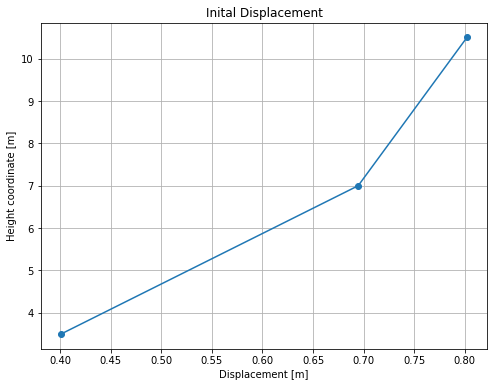

In [16]:
plt.figure(num=4, figsize=(8, 6))
plt.plot(vu0, z[1:],marker='o')
plt.title("Inital Displacement")
plt.xlabel("Displacement [m]")
plt.ylabel("Height coordinate [m]")
plt.grid(True)

###### External loading  

Two types of loads are defined here. 
1. Free vibration case - no external loads
2. Harmonic excitation

In [17]:
# for no external force
ext_force = np.zeros((len(vu0),len(time_series)))

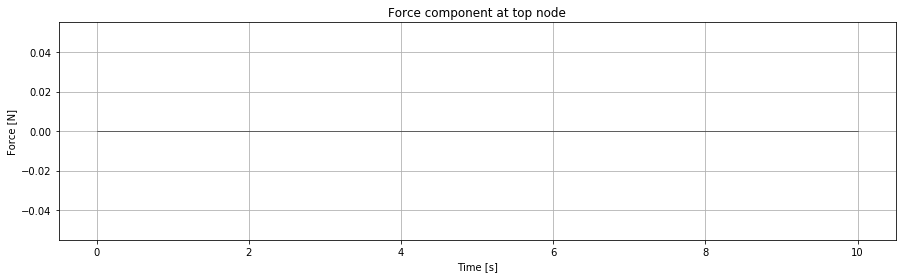

In [18]:
# plot for force - for top dof
plt.figure(num=5, figsize=(15, 4))
plt.plot(time_series, ext_force[m.shape[0]-1,:], "-k", lw=0.5)
plt.ylabel('Force [N]')
plt.xlabel('Time [s]')
plt.title("Force component at top node")
plt.grid(True)

##### Time integration schemes 

For solving the equation of motion at each time step different time integration schemes can be used.
Here in this exercise three time integration implementations are available. 
1. Euler 1st : The acceleration is approximated by 1st order Euler of velocity and the velocity is approximated by !st order Euler of displacement  
2. Euler !st and 2nd : Here the acceleration is approximated by 2nd order Euler of displacements and the displacement is approximated by 1st order Euler of displacements. The forward, backward and central Euler are available for the velocities ( check block 12 for details)
3. A Generalized alpha method for time integration.  

In [19]:
# numerical parameter -> only needed for the GeneralizedAlpha time integration scheme
p_inf = 0.15 
# create an object: structure - to be used by the GeneralizedAlpha scheme
structure = s_mdof.StructureMDoF(delta_time, m, b, k, p_inf, vu0, vv0, va0)
# structure.print_setup()

##### Tip: Have a look at "structure_mdof.py" for details 

In [20]:
# data for storing results
# using objects 
# standard python dictionaries would also be a good option
# create a SampleData class
class SampleData(): pass

# initiate objects and labels
data_euler12 = SampleData()
data_euler12.label = "Euler 1st & 2nd"

data_gen_alpha = SampleData()
data_gen_alpha.label = "Gen Alpha"

# lists to store the results
data_euler12.disp = []
data_euler12.acc  = []
data_euler12.vel  = []

data_gen_alpha.disp = []
data_gen_alpha.acc  = []
data_gen_alpha.vel  = []

# ===============================================================================
# computation time for each method
data_euler12.computation_time = 0.0
data_gen_alpha.computation_time = 0.0

# initial values
data_euler12.disp.append(vu0)
data_euler12.vel.append(vv0)
data_euler12.acc.append(va0)

data_gen_alpha.disp.append(vu0)
data_gen_alpha.vel.append(vv0)
data_gen_alpha.acc.append(va0)

# more initial values for the time integration schemes
data_euler12.un2 = vu0
data_euler12.un1 = vu0 - (vv0*delta_time) + (delta_time ** 2 / 2) * va0
data_euler12.vn1 = vv0
data_euler12.an1 = va0

###### Time loop: computing the response at each time instant
interested students may refer to [J.L. Cieslinski, B. Ratkiewicz](https://link.springer.com/content/pdf/10.1155%2FADE%2F2006%2F40171.pdf) (2006) for details on discretization of Euler time integration 

In [21]:
for i in range(1, len(time_series)):
    currentTime = time_series[i]

    # ===========================================================================
    ## Euler 1st and 2nd order
    t = time.time()

    # solve the time integration step
    # second order approximation of acceleration, first order for velocity
    # version 1 - eq. 5.3
    # LHS = m
    # RHS = ext_force[i-1] * delta_time**2 
    # RHS += np.dot(data_euler12.un1, (2*m - b * delta_time - k *delta_time**2)) 
    # RHS += np.dot(data_euler12.un2, (-m + b * delta_time))
    
    # version 2 - eq. 5.4 from J.L. Cieslinski, B. Ratkiewicz or eq. 6 from H.P. Gavin
    LHS = m + np.dot(b, delta_time / 2)
    RHS = ext_force[:,i] * delta_time ** 2 
    RHS += np.dot(data_euler12.un1, (2 * m - k * delta_time ** 2)) 
    RHS += np.dot(data_euler12.un2, (-m + b * delta_time / 2))
    
    # version 3 - eq. 5.5
    # LHS = m + b * delta_time
    # RHS = ext_force[i-1] * delta_time**2 
    # RHS += np.dot(data_euler12.un1, (2*m + b * delta_time - k *delta_time**2)) 
    # RHS += np.dot(data_euler12.un2, (-m))

    data_euler12.un0 = np.linalg.solve(LHS, RHS)

    data_euler12.vn0 = (data_euler12.un0 - data_euler12.un2) / 2 / delta_time
    data_euler12.an0 = (data_euler12.un0 - 2 * data_euler12.un1 + data_euler12.un2) / delta_time ** 2

    # append results to list
    data_euler12.disp.append(data_euler12.un0)
    data_euler12.vel.append(data_euler12.vn0)
    data_euler12.acc.append(data_euler12.an0)

    # update results
    data_euler12.un2 = data_euler12.un1
    data_euler12.un1 = data_euler12.un0

    # elapsed time accumulated
    data_euler12.computation_time += time.time() - t

    # ===========================================================================
    ## Generalized Alpha
    t = time.time()

    # solve the time integration step
    structure.solve_structure(ext_force[:,i])

    # append results to list
    data_gen_alpha.disp.append(structure.get_displacement())
    data_gen_alpha.vel.append(structure.get_velocity())
    data_gen_alpha.acc.append(structure.get_acceleration())

    # update results
    structure.update_structure_timestep()

    # elapsed time accumulated
    data_gen_alpha.computation_time += time.time() - t

In [22]:
# plot results
# select Nodal DoF (for this case equivalent to story height)
node = 3
dof = node-1
x_axis_end = end_time

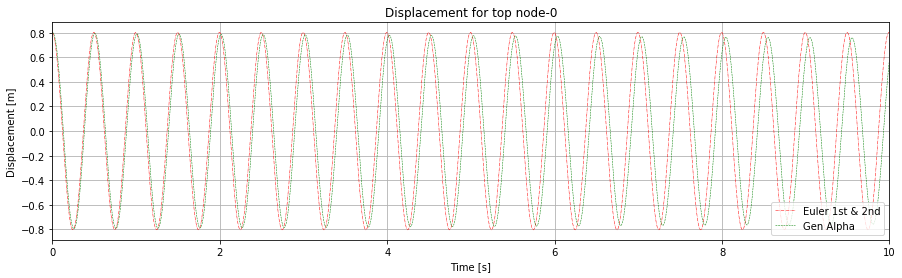

In [23]:
# plot for displacement - top dof
plt.figure(num=6, figsize=(15, 4))
plt.plot(time_series, [row[dof] for row in data_euler12.disp], "-.r", label=data_euler12.label, lw=0.5)
plt.plot(time_series, [row[dof] for row in data_gen_alpha.disp], "--g", label=data_gen_alpha.label, lw=0.5)
plt.xlim([0, x_axis_end])
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title("Displacement for top node-0")
plt.legend(loc=4)
plt.grid(True)

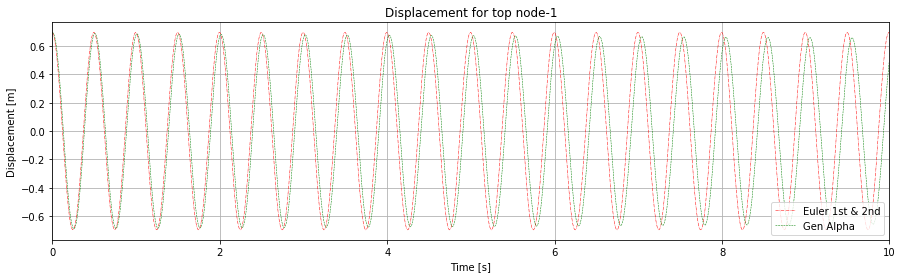

In [24]:
# plot for displacement - top dof
plt.figure(num=7, figsize=(15, 4))
plt.plot(time_series, [row[dof-1] for row in data_euler12.disp], "-.r", label=data_euler12.label, lw=0.5)
plt.plot(time_series, [row[dof-1] for row in data_gen_alpha.disp], "--g", label=data_gen_alpha.label, lw=0.5)
plt.xlim([0, x_axis_end])
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.title("Displacement for top node-1")
plt.legend(loc=4)
plt.grid(True)

plt.show()

### Exercise 1: Dynamic analysis under harmonic loads

Apply a harmonic load excited in mode 1 with no initial displacement. Observe the difference in response.

Tip: 
1. The inital displacement needs to be made zero. Use the appropriate contents of block 25 in block 15 
2. A harmonic external force excited in mode 1 needs to be defined. Use the appropriate contents of block 25 in block 17 
(use 'Ctrl' + '/' to uncomment multiple lines)

In [25]:
# # initial displacement vector - set to zero for zero initial displacement and forced vibration case 
# vu0 = np.zeros(m.shape[0])
# # copy the above lines to block 15
                       
# # for harmonic excitation
# scaling_factor = 1.5
# # select mode to excite harmonically
# mode = 1
# i = mode -1
# for j in range(len(time_series)):
#     ext_force[:,j] = eig_modes_norm[:, eig_freq_sorted_idx[i]]
#     ext_force[:,j] *= scaling_factor
#     ext_force[:,j] *= np.sin(eig_vals[eig_freq_sorted_idx[i]] * time_series[j])
# # copy the above lines to block 17                       

### Exercise 2: Dynamic analysis of MDoF model of a high rise

Import the MDoF model of the highrise provided, and compute the responses . 

Tip : 
1. Use the mass, stiffness, and damping matrix definitions of block 26 in block 3. (use 'Ctrl' + '/' to uncomment multiple lines)

In [26]:
# # import or read-in -> sample data for a generic highrise
# import mdof_model_highrise as m_highrise
# # stiffness matrix
# k = m_highrise.get_stiffness()
# # mass matrix
# m = m_highrise.get_mass()
# # height coordinates
# z = m_highrise.get_height_coordinates()
# #copy the above lines to block 3

### Exercise 3: Modify the time step delta_time 

Modify the time step *delta_time* by changing the number of timesteps *n_steps*. Comment on the results.

### Exercise 4: Modify p_inf

Modify the numerical parameter *p_inf* (for the Generalized Alpha scheme), observe and comment on the result.

 ## Check Point: Discussion

#### Discuss among groups the observations and outcomes from exercises.

### Assignment: Apply wind loads

Create and apply a static load case of the wind profile already determined, also apply a dynamic version of it. See the notes and exercises related to Bluff Body Aerodynamics.

For example: The wind load for a wind velocity of 28.7 m/s at reference height of 10 m is as in block 27. Use the snippet in block 27 to adapt block 4.

In [27]:
# velocity_over_height = 1.05 * 28.7 * pow(z[1:]/10, 0.2)
# static_force = 0.5 * 1.2 * 600 * velocity_over_height**2